# Remove Instrument Response

This is an example notebook for removing the instrument response to calibrate the data into physical units.

All the filters are represented as `mt_metadata.timeseries.filters` objects.  More information about these can be found in [mt_metadata filters](https://mt-metadata.readthedocs.io/en/latest/source/notebooks/filters_example.html).

This example will read in an existing MTH5 that has one station `CAS04`, one run `a`, and 2 channels `ex` and `hx`. 

In [1]:
from mth5.mth5 import MTH5

2022-04-08T14:47:07 [line 157] numexpr.utils._init_num_threads - INFO: NumExpr defaulting to 8 threads.


2022-04-08 14:47:10,598 [line 135] mth5.setup_logger - INFO: Logging file can be found C:\Users\jpeacock\Documents\GitHub\mth5\logs\mth5_debug.log


## Open the MTH5 file

This has 2 stations in it CAS04 and NVR08 both MTArray/Earthscope stations.  Each only has one run.  

In [2]:
m = MTH5()
m.open_mth5(r"c:\Users\jpeacock\Documents\GitHub\mth5\docs\examples\notebooks\ZU_CAS04_NVR08_small.h5")

Have a look at the channel summary.  This is a table of all the channels available in the MTH5 file.

In [3]:
ch_df = m.channel_summary.to_dataframe()
ch_df

,survey,station,run,latitude,longitude,elevation,component,start,end,n_samples,sample_rate,measurement_type,azimuth,tilt,units,hdf5_reference,run_hdf5_reference,station_hdf5_reference
0,CONUS South,CAS04,a,37.633351,-121.468382,329.3875,ex,2020-06-02 19:00:00+00:00,2020-06-02 22:07:46+00:00,11267,1.0,electric,13.2,0.0,digital counts,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>
1,CONUS South,CAS04,a,37.633351,-121.468382,329.3875,hx,2020-06-02 19:00:00+00:00,2020-06-02 22:07:46+00:00,11267,1.0,magnetic,13.2,0.0,digital counts,<HDF5 object reference>,<HDF5 object reference>,<HDF5 object reference>


## Get EX channel

Here we will get an EX channel, it will return a `channel_dataset` object. 

Change `ex` to `hx` to look at the magnetic channels

In [105]:
ex = m.get_channel("CAS04", "a", "ex", survey="CONUS_South")

In [73]:
ex

Channel Electric:
-------------------
	component:        ex
	data type:        electric
	data format:      int32
	data shape:       (11267,)
	start:            2020-06-02T19:00:00+00:00
	end:              2020-06-02T22:07:46+00:00
	sample rate:      1.0

### ChannelTS object

Convert the `ex` channel to a `ChannelTS` object which is based on an `xarray.DataArray` and has methods to working with the data.  More information can be found [Time Series Objects](https://mth5.readthedocs.io/en/latest/source/ts.html)

In [106]:
exts = ex.to_channel_ts()

### Channel Response Filter

With the `ChannelTS` object comes the `ChannelResponseFilter` object.  This includes all the filters that need to be applied to convert to physical units.  Here we print out what the `channel_response_filter` attribute includes.

In [75]:
exts.channel_response_filter

Filters Included:
pole_zero_filter:
	calibration_date = 1980-01-01
	comments = butterworth filter
	gain = 1.0
	name = electric field 5 pole butterworth low-pass
	normalization_factor = 313383.601119193
	poles = [ -3.883009+11.951875j  -3.883009-11.951875j -10.166194 +7.386513j
 -10.166194 -7.386513j -12.566371 +0.j      ]
	type = zpk
	units_in = mV/km
	units_out = mV/km
	zeros = []
--------------------
pole_zero_filter:
	calibration_date = 1980-01-01
	comments = butterworth filter
	gain = 1.0
	name = electric field 1 pole butterworth high-pass
	normalization_factor = 1.00000351809047
	poles = [-0.000167+0.j]
	type = zpk
	units_in = mV/km
	units_out = mV/km
	zeros = [ 0.+0.j]
--------------------
coefficient_filter:
	calibration_date = 1980-01-01
	comments = unit conversion
	gain = 1e-06
	name = mv per km to v per m
	type = coefficient
	units_in = mV/km
	units_out = V/m
--------------------
coefficient_filter:
	calibration_date = 1980-01-01
	comments = electric dipole
	gain = 94.0
	name

### Plot the channel response

The gray areas are the *pass band* of the filters and the vertical black line is the *normalization frequency*.  These are estimated values.  

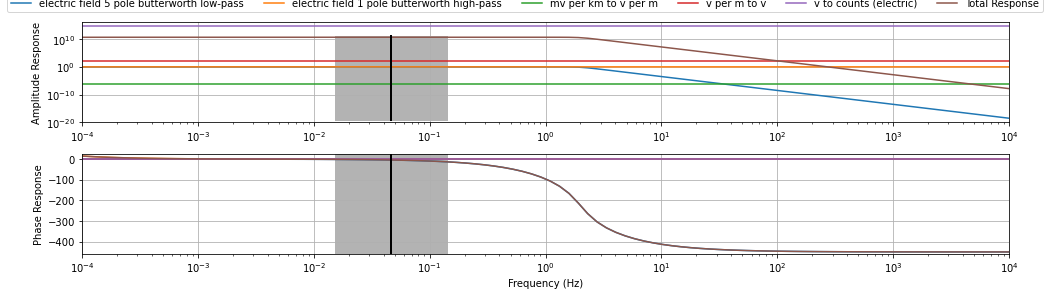

In [8]:
exts.channel_response_filter.plot_response(x_units="frequency")

## Remove Instrument Response

Here we will attempt to remove the instrument response to calibrate the data in physical units.  Create a few helper functions 

- `zero_pad` will pad an input array to a power of 2.

In [9]:
import numpy as np
from scipy import signal
from matplotlib import pyplot as plt

In [10]:
%matplotlib widget

In [27]:
def zero_pad(input_array, power=2, pad_fill=0):
    """
    pad the input array with pad_fill to the next power of power.  
    
    For faster fft computation pad the array to the next power of 2 with zeros
    
    Arguments:
    -----------
        **input_array** : np.ndarray (only 1-d arrays are supported at the 
                                      moment)
        
        **power** : [ 2 | 10 ]
                    power look for
        
        **pad_fill** : float or int
                       pad the array with this
                       
    Output:
    --------
        **pad_array** : np.ndarray padded with pad_fill
        
    """

    len_array = input_array.shape[0]
    if power == 2:
        npow = int(np.ceil(np.log2(len_array)))
    if power == 10:
        npow = int(np.ceil(np.log10(len_array)))

    if npow > 32:
        logger.warning(
            "Exceeding memory allocation inherent in your computer 2**32. "
            "Limiting the zero pad to 2**32"
            )

    pad_array = np.zeros(power ** npow)
    if pad_fill != 0:
        pad_array[:] = pad_fill

    pad_array[0:len_array] = input_array

    return pad_array

In [12]:
def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        
        if lowcut is not None:
            low = lowcut / nyq
        
        if highcut is not None:
            high = highcut / nyq
            
        if lowcut and highcut:
            sos = signal.butter(order, [low, high], analog=False, btype='band', output='sos')
            
        elif highcut is None:
            sos = signal.butter(
                order, 
                low,
                analog=False,
                btype='low',
                output='sos')
            
        elif lowcut is None:
             sos = signal.butter(
                 order, high, analog=False, btype='high', output='sos'
                 )
        return sos

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
        sos = butter_bandpass(lowcut, highcut, fs, order=order)
        y = signal.sosfiltfilt(sos, data)
        return y

In [258]:
def _subplots(x, y, fig, sample_rate, color, nrows, num, label):
    ax_t = fig.get_axes()[0]
    ax_f = fig.get_axes()[1]
    ax = fig.add_subplot(nrows, 2, num, sharex=ax_t)
    ax2 = fig.add_subplot(nrows, 2, num+1, sharex=ax_f)

    # plot time series
    l1, ax.plot(x, y, color=color)
    f = np.fft.rfftfreq(x.size, d=sample_rate)
    #plot spectra
    data = np.fft.rfft(y)
    ax2.loglog(f, abs(data), color=color)
    ax.set_ylabel(label)

    return l1

def get_window(window, window_params, size):
    return getattr(signal.windows, window)(size, **window_params)

def apply_window(ts, window, window_params, wtype="t", plot=True, time_array=None, fig=None, sample_rate=1, subplot_dict=None):
    """
    apply a time domain window
    """
    w = get_window(window, window_params, ts.size)
    ts = ts * w
    
    if plot:
        if time_array is None:
            time_array = np.arange(ts.size)
        if wtype == "t":
            color = (.7, .1, .25)
        else:
            color = (.75, .1, .2)
        l1 = _subplots(time_array, ts, fig, sample_rate, color, subplot_dict["nrows"], subplot_dict[f"{wtype}_window"], f"{wtype}_window {window}")
        
        return ts, l1
    return ts, None
    
def apply_detrend(ts, plot=True, time_array=None, fig=None, sample_rate=1, subplot_dict=None):
    """
    detrend data with scipy.detrend
    """
    ts = signal.detrend(ts, type="linear")
    
    if plot:
        if time_array is None:
            time_array = np.arange(ts.size)
        l1 = _subplots(time_array, ts, fig, sample_rate, (.45, .1, .5), subplot_dict["nrows"], subplot_dict["detrend"], "Detrended") 
        
        return ts, l1
    return ts, None

def apply_zero_mean(ts, plot=True, time_array=None, fig=None, sample_rate=1, subplot_dict=None):
    """
    remove mean
    """
    ts = ts - ts.mean()
    
    if plot:
        if time_array is None:
            time_array = np.arange(ts.size)
        l1 = _subplots(time_array, ts, fig, sample_rate, (.55, .1, .4), subplot_dict["nrows"], subplot_dict["zero_mean"], "Zero Mean") 
        
        return ts, l1
    return ts, None
    
def apply_zero_pad(ts, plot=True, time_array=None, fig=None, sample_rate=1, subplot_dict=None):
    """
    zero pad to power of 2, at the end of the time series
    """
    
    pad_ts = zero_pad(ts)

    if plot:
        if time_array is None:
            time_array = np.arange(pad_ts.size)
        else:
            dt = int(1./sample_rate * 1000000000)
            diff = int(((pad_ts.size - ts.size)+ 1) * dt)
            time_array = np.arange(time_array[0], time_array[-1] + np.timedelta64(diff), np.timedelta64(dt), dtype='datetime64[ns]')
        l1 = _subplots(time_array, pad_ts, fig, sample_rate, (.7, .1, .25), subplot_dict["nrows"], subplot_dict["pad"], "Zero Pad") 
        
        return pad_ts, l1
    return pad_ts, None
    
    
def get_subplot_count(pad, zero_mean, detrend, t_window, f_window):
    order = ["detrend", "zero_mean", "t_window", "pad", "f_window"]
    pdict = {"pad": pad, "zero_mean": zero_mean, "detrend": detrend, "t_window": t_window, "f_window":f_window}
    subplot_dict = {}
    count = 3
    nrows = 2
    for key in order:
        value = pdict[key]
        if value:
            subplot_dict[key] = count
            count += 2
            nrows += 1
    subplot_dict["nrows"] = nrows
            
    return subplot_dict
    
def remove_instrument_response(channel_obj, pad=False, zero_mean=True, detrend=False, t_window=None, t_window_params={}, f_window=None, f_window_params={}, plot=True):
        """
        Arguments
        -----------
        
            **data**: data array (np.ndarray)
            
            **sample_rate**: sample rate of the data
            
            **window**: a scipy.signal.windows name
            
            **window_params**: dictionary of window parameters
            
        for a working example with seismic data see https://github.com/obspy/obspy/blob/master/obspy/core/trace.py `remove_response`
        
        """
        ts = np.copy(channel_obj.ts)
        sr = channel_obj.sample_interval
        f = np.fft.rfftfreq(ts.size, d=sr)
        if plot:
            subplot_dict = get_subplot_count(pad, zero_mean, detrend, t_window, f_window)
            fig = plt.figure(1)
            fig.clf()
            ax = fig.add_subplot(subplot_dict["nrows"], 2, 1)
            ax2 = fig.add_subplot(subplot_dict["nrows"], 2, 2)
            t = channel_obj._ts.time.to_numpy()
            l1, = ax.plot(t, ts, color="k", lw=2)
            l2, = ax2.loglog(f, abs(np.fft.rfft(ts)), "k", lw=2)
            ax.set_ylabel("Original")
        
        # detrend
        if detrend:
            ts, dtrend_line = apply_detrend(ts, plot, t, fig, sr, subplot_dict)
            print("Applying detrend")
        # zero mean
        if zero_mean:
            ts, zm_line = apply_zero_mean(ts, plot, t, fig, sr, subplot_dict)
            print("Applying zero mean")
            
        # filter in time domain
        if t_window is not None:
            ts, tw_line = apply_window(ts, t_window, t_window_params, "t", plot, t, fig, sr, subplot_dict)
            print("Applying time window")
            if plot:
                print(len(fig.get_axes()))
                print(subplot_dict["t_window"])
                wax = fig.get_axes()[subplot_dict["t_window"] - 1]
                tw, = wax.plot(t, get_window(t_window, t_window_params, ts.size), color=(.75, .75, .75))
            
        if pad:
            # pad the time series to a power of 2, this may be overkill, especially for long time series
            ts, zp_line = apply_zero_pad(ts, plot, t, fig, sr, subplot_dict)
            print("Applying zero pad")

        # get the real frequencies of the FFT
        f = np.fft.rfftfreq(ts.size, d=channel_obj.sample_interval)
        
        if channel_obj.channel_response_filter.filters_list is []:
            raise ValueError("There are no filters in channel_response to remove")
        
        # compute the complex response given the frequency range of the FFT
        # the complex response assumes frequencies are in reverse order and flip them on input
        # so we need to flip the complex reponse so it aligns with the fft.
        cr = channel_obj.channel_response_filter.complex_response(f)[::-1]
        # remove the DC term at frequency == 0
        cr[-1] = abs(cr[-2]) + 0.0j
        
        #if plot:
        #    cr_line, = ax2.loglog(f, abs(cr), color=(.25, .7, .25))
        
        data = np.fft.rfft(ts)
        # remove DC term
        data[-1] = abs(data[-1]) + 0.0j
        #if plot:
        #    d_line, = ax2.loglog(f, abs(data), color=(.75, .75, .75))
        
        # if a window is requested then create it here and mulitply by the data
        # the windows are designed to be symmetrical about frequency = 0
        # here we are taking only the real part of the FFT so we cut the window in half
        if f_window is not None:
            data, fw_line = apply_window(data, f_window, f_window_params, plot=plot, time_array=t, fig=fig, sample_rate=sr)
            legend_lines.append(fw_line)
            legend_labels.append(f"Frequency windowed")
            #if plot:
            #    tw, = ax2.loglog(f, get_window(f_window, f_window_params, data.size), color=(.75, .75, .75))
        
        # calibrate the time series, compute real part of fft, divide out channel response, inverse fft
        calibrated_ts = np.fft.irfft(data / cr)[0:channel_obj.ts.size]
        
        if plot:
            lc = _subplots(t[0:calibrated_ts.size], calibrated_ts, fig, sr, (.95, .2, .1), subplot_dict["nrows"], subplot_dict["nrows"] * 2 -1, "Calibrated") 

            plt.show()
            
        return calibrated_ts

## Test the calibration function

C:\Users\jpeacock\Anaconda3\envs\mt\lib\site-packages\ipykernel_launcher.py:125: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


Applying detrend
Applying zero mean
Applying time window
8
7
Applying zero pad


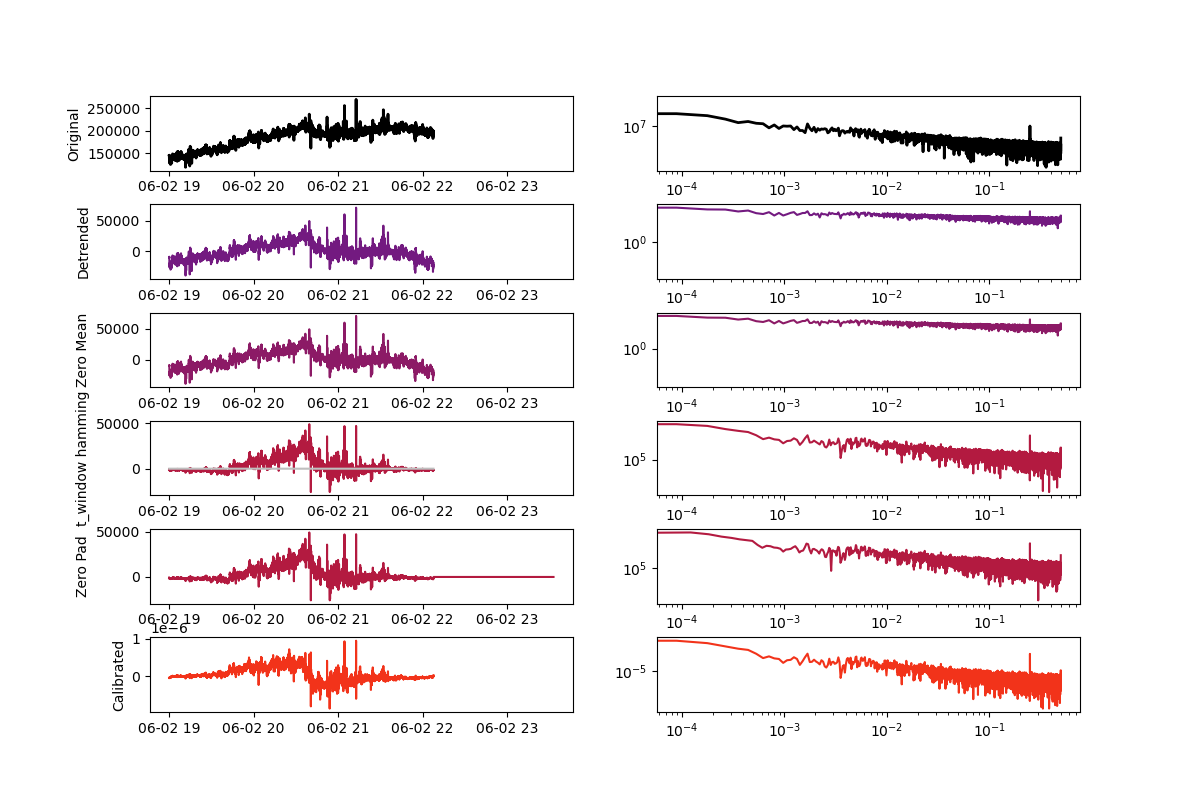

In [259]:
calibrated_ex = remove_instrument_response(exts, zero_mean=True, detrend=True, pad=True, t_window="hamming", t_window_params={}, plot=True)

In [113]:
# apply a bandpass otherwise low frequencies get blown up
bp_calibrated_ts = butter_bandpass_filter(calibrated_ex, .0001, .35, exts.sample_rate, order=1)

## Plot response and look at the differences

The big difference are at the ends of the time series which have to do with the window applied and the calibration.  Need to figure out a good scheme to reduce those effects.  

- Better window
- Better padding
- Better removal scheme

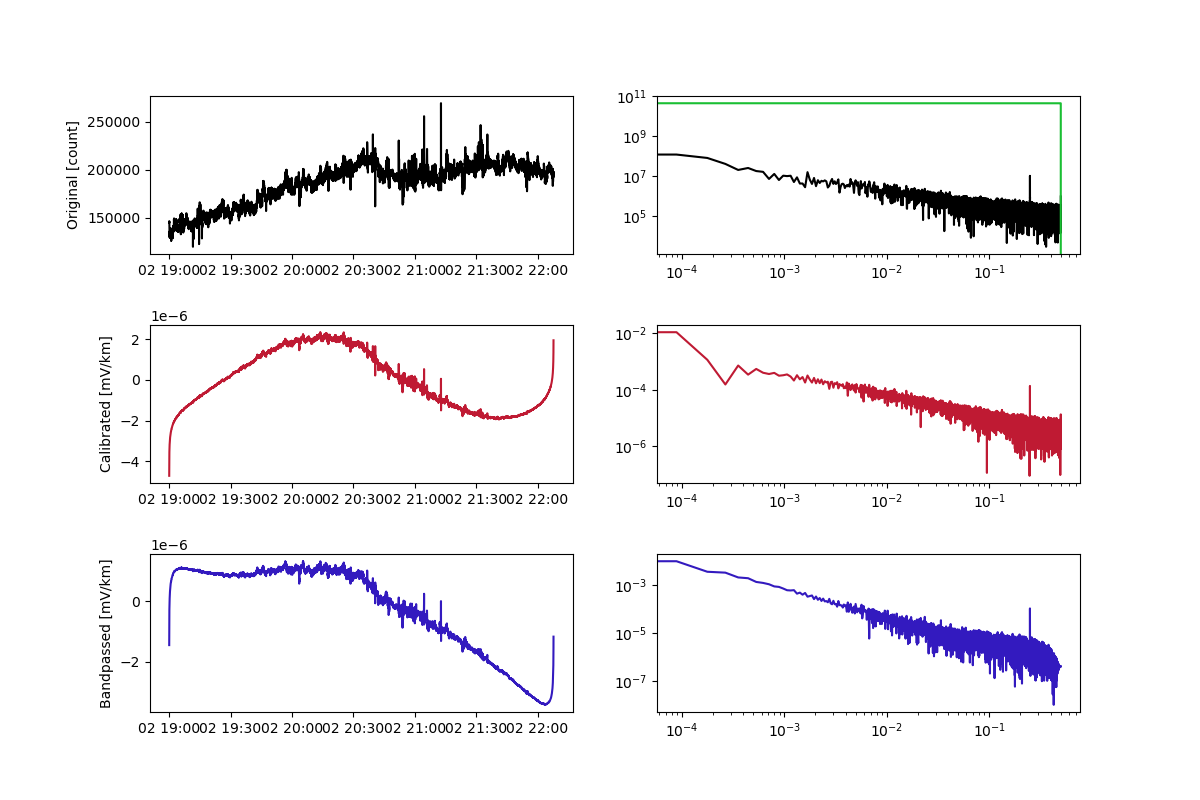

In [114]:
plt.rcParams["figure.subplot.hspace"] = .45

f = np.fft.rfftfreq(calibrated_ex.size, d=exts.sample_interval)

fig = plt.figure(figsize=[12, 8])
ax_original = fig.add_subplot(3, 2, 1)
l1, = ax_original.plot(exts._ts.time, exts.ts, color=(0, 0, 0))
ax_original.set_ylabel(f"Original [{exts.channel_response_filter.units_out}]")

ax_original_fft = fig.add_subplot(3, 2, 2)
l1, = ax_original_fft.loglog(f, abs(np.fft.rfft(exts.ts)), color=(0, 0, 0))
ax_original_fft.loglog(f, abs(exts.channel_response_filter.complex_response(f)[::-1]), color=(.1, .75, .2))

ax_calibrated = fig.add_subplot(3, 2, 3, sharex=ax_original)
l2, = ax_calibrated.plot(exts._ts.time, calibrated_ex, color=(.75, .1, .2))
ax_calibrated.set_ylabel(f"Calibrated [{exts.channel_response_filter.units_in}]")

ax_calibrated_fft = fig.add_subplot(3, 2, 4, sharex=ax_original_fft)
l2, = ax_calibrated_fft.loglog(f, abs(np.fft.rfft(calibrated_ex)), color=(.75, .1, .2))

ax_bandpassed = fig.add_subplot(3, 2, 5, sharex=ax_original)
l3, = ax_bandpassed.plot(exts._ts.time, bp_calibrated_ts, color=(.2, .1, .75))
ax_bandpassed.set_ylabel(f"Bandpassed [{exts.channel_response_filter.units_in}]")

ax_bandpassed_fft = fig.add_subplot(3, 2, 6, sharex=ax_original_fft)
l3, = ax_bandpassed_fft.loglog(f, abs(np.fft.rfft(bp_calibrated_ts)), color=(.2, .1, .75))

fig.canvas.toolbar_visible = True
fig.canvas.header_visible = True
fig.canvas.resizable = True

plt.show()

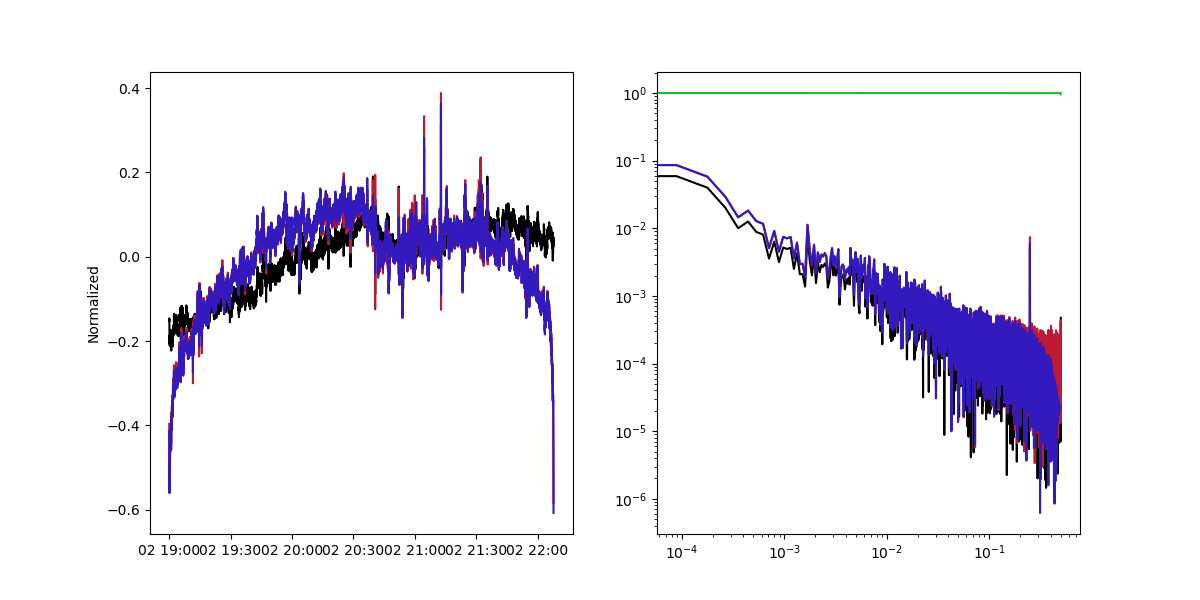

In [88]:
fig = plt.figure(figsize=[12, 6])
ax_original = fig.add_subplot(1, 2, 1)
l1, = ax_original.plot(exts._ts.time, (exts.ts / exts.ts.max()) - (exts.ts / exts.ts.max()).mean(), color=(0, 0, 0))
l2, = ax_original.plot(exts._ts.time, (calibrated_ex / calibrated_ex.max()) - (calibrated_ex / calibrated_ex.max()).mean(), color=(.75, .1, .2))
l3, = ax_original.plot(exts._ts.time, (bp_calibrated_ts / bp_calibrated_ts.max()) - (bp_calibrated_ts / bp_calibrated_ts.max()).mean(), color=(.2, .1, .75))
ax_original.set_ylabel("Normalized")

ax_original_fft = fig.add_subplot(1, 2, 2)
original = abs(np.fft.rfft(exts.ts))
calibrated = abs(np.fft.rfft(calibrated_ex))
response = abs(exts.channel_response_filter.complex_response(f))[::-1]
response[-1] = response[-2]
bp = abs(np.fft.rfft(bp_calibrated_ts))
l1, = ax_original_fft.loglog(f, original / original.max(), color=(0, 0, 0))
l2, = ax_original_fft.loglog(f, calibrated / calibrated.max(), color=(.75, .1, .2))
l2, = ax_original_fft.loglog(f, bp / bp.max(), color=(.2, .1, .75))
l4, = ax_original_fft.loglog(f, response / response.max(), color=(.1, .75, .2))

fig.canvas.toolbar_visible = True
fig.canvas.header_visible = True
fig.canvas.resizable = True

plt.show()

2022-04-08 14:47:15,448 [line 310] mt_metadata.base.metadata.pole_zero_filter.pass_band - WARNING: No pass band could be found within the given frequency range. Returning None
2022-04-08 14:47:15,504 [line 310] mt_metadata.base.metadata.coefficient_filter.pass_band - WARNING: No pass band could be found within the given frequency range. Returning None
2022-04-08 14:47:15,564 [line 310] mt_metadata.base.metadata.coefficient_filter.pass_band - WARNING: No pass band could be found within the given frequency range. Returning None
2022-04-08 14:47:15,621 [line 310] mt_metadata.base.metadata.coefficient_filter.pass_band - WARNING: No pass band could be found within the given frequency range. Returning None
2022-04-08 14:47:15,681 [line 310] mt_metadata.base.metadata.pole_zero_filter.pass_band - WARNING: No pass band could be found within the given frequency range. Returning None
2022-04-08 14:47:15,731 [line 310] mt_metadata.base.metadata.coefficient_filter.pass_band - WARNING: No pass band 

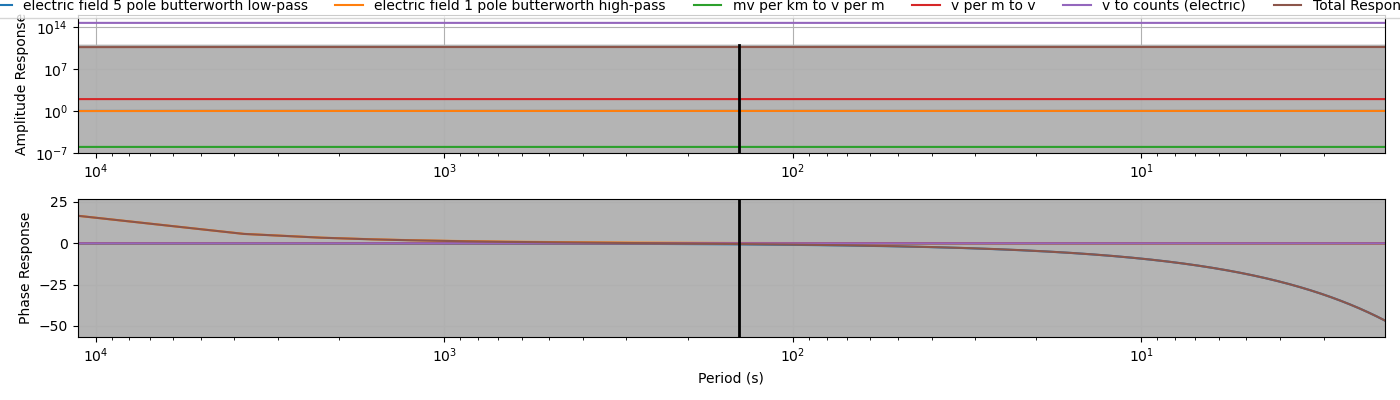

In [18]:
exts.channel_response_filter.plot_response(f[::-2])

In [19]:
#m.close_mth5()

In [115]:
fig.get_axes()


[<AxesSubplot:ylabel='Original [count]'>,
 <AxesSubplot:>,
 <AxesSubplot:ylabel='Calibrated [mV/km]'>,
 <AxesSubplot:>,
 <AxesSubplot:ylabel='Bandpassed [mV/km]'>,
 <AxesSubplot:>]

In [132]:
exts._ts.time.dtype

dtype('<M8[ns]')

In [133]:
np.zeros_like(exts._ts.time)

array(['1970-01-01T00:00:00.000000000', '1970-01-01T00:00:00.000000000',
       '1970-01-01T00:00:00.000000000', ...,
       '1970-01-01T00:00:00.000000000', '1970-01-01T00:00:00.000000000',
       '1970-01-01T00:00:00.000000000'], dtype='datetime64[ns]')

In [151]:
np.arange(exts._ts.time[0].values, exts._ts.time[0].values + np.timedelta64(10* 1000000000), np.timedelta64(1000000000),dtype='datetime64[ns]')

array(['2020-06-02T19:00:00.000000000', '2020-06-02T19:00:01.000000000',
       '2020-06-02T19:00:02.000000000', '2020-06-02T19:00:03.000000000',
       '2020-06-02T19:00:04.000000000', '2020-06-02T19:00:05.000000000',
       '2020-06-02T19:00:06.000000000', '2020-06-02T19:00:07.000000000',
       '2020-06-02T19:00:08.000000000', '2020-06-02T19:00:09.000000000'], dtype='datetime64[ns]')

In [140]:
exts._ts.time[0].values

numpy.datetime64('2020-06-02T19:00:00.000000000')

In [160]:
dt = int(1./1 * 1000000000)
exts._ts.time[0].values + np.timedelta64(dt)

numpy.datetime64('2020-06-02T19:00:01.000000000')

In [168]:
exts._ts.time[-1] + np.timedelta64(5117000000000)

<xarray.DataArray 'time' ()>
array(1591140783000000000, dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2020-06-02T22:07:46

In [169]:
exts._ts.time.to_numpy()

array(['2020-06-02T19:00:00.000000000', '2020-06-02T19:00:01.000000000',
       '2020-06-02T19:00:02.000000000', ...,
       '2020-06-02T22:07:44.000000000', '2020-06-02T22:07:45.000000000',
       '2020-06-02T22:07:46.000000000'], dtype='datetime64[ns]')